# TO DO LISTA
------------------
1. Opis zadania - *description of the task*
2. Uzyskanie danych - *getting the data*
3. Odkryć i zwizuwalizować dane, rozpoznać dodatkowe informacje **BRAK** - *explore data*
4. Przygotować dane pod względem algorytmów maszynowego uczenia - *transform data*
5. Wybrać i wyuczyć model - *choose and learn a model*
6. Dostroić model - *tune the model*
------------------
7. Zaprezentować rozwiązanie (vide - ocena modelu) - *evaluation of the model*
8. Przygotowć potok. Podzielić na katologi produkcyjne. Pokryć sieć testami jednostkowymi - *pipeline*
------------------
9. **Uruchomić (DOCKER | REST API)**, monitorować i utrzymać system - *launch docker*
------------------


1. **Opis zadania.** <br>
Celem zadania jest porównanie wyników uzyskanych w środowiskach **Matlab i TF**. Do jego osięgnięcia należy wykonać trening modelu zgodnie z obecnym stanem wiedzy. Jeżeli wynik **MSE** będzie porównywalny lub nie zostaną stwierdzone mankamenty modelu podstawowego `(2018)`, wykonany zostanie również krok **7, 8**. Krok **9** polega na uruchomieniu SSN z użyciem środowiska `Docker` i zapytania `REST API`. Przygotowanie do głównego zadania poprzedzono wykonanie dwóch etapów: <br><br>
**etap 1)** transfer `sieć opracowanej w środowisku Matlab` do języka python  (postać analityczna)<br><br>
**etap 2)** transfer współczyników W i b (wag i obciążeń) `do środowiska Keras`<br><br>
Każdorazowo wyniki predykcji były weryfikowane wględem pierwotnych wartości (sieć z 2018). Wykorzystanie `TF` ma na celu użycie technik opracowanych dla potrzeb głębokiego uczenia. Kryterium wyboru nowej sieci będzie `R_new > R_old` (przy założeniu prawidłowo uzyskanego modelu tj. brak przetrenowania itp.). <br><br>



2. **Uzyskanie danych**

    dane są nie pełne - kończą się na 2017 roku *(ponowne przeuczenie zostanie wykonane po uzupełnieniu danych z lat 2018 - 2022)*
------------------

In [1]:
import pandas as pd
import numpy as np
#import joblib
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as measures
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras

In [2]:
from my_tools import hold_data
from my_tools_alfa import checker_dist_box
from my_tools_alfa import num1 #lecun selu
"""from my_tools import plot_train_via_neurons
from my_tools import plot_box_via_neurons
from my_tools import checker_dist_box"""

'from my_tools import plot_train_via_neurons\nfrom my_tools import plot_box_via_neurons\nfrom my_tools import checker_dist_box'

In [32]:
%load_ext autoreload
%autoreload 2

In [3]:
#raw data
pd.read_excel('data_raw.xlsx', sheet_name = 'tabela', engine = 'openpyxl')

,Rodzaj skał stropowych,Wytrzymałość na rozciąganie,Spękania pionowe,Zawodnienie,Płaszczyzny osłabienia,Występowanie zaburzeń zalegania złoża,Średni postęp miesięczny frontu,Średni postęp mieś. likwidacji,"Występowanie zaszłości (stare wyrobiska, zroby)",Głębokość zalegania złoża,Rzeczywista szerokość,Długość kotwi,Dodatkowa obudowa,Czas istnienia wyrobiska,Opadnięcia elementów SRS,Rozwarstwienia stwierdzone badaniem endoskopowym,Predyspozycja,Możliwość utrzymania
0,5,11.80,0.0,0.3,0.0,0.0,18,18,0,1.10,17.5,1.8,0,3.5,0.0,0.0,1.00,1.0
1,4,9.60,0.0,0.3,0.5,0.5,30,30,0,0.85,12.0,1.6,2,6.0,0.0,1.5,1.00,1.0
2,56,9.30,0.0,0.0,0.0,0.6,8,8,75,0.95,11.6,1.8,5,1.0,0.0,0.0,1.00,1.0
3,4,8.70,1.0,0.3,0.0,0.0,0,0,0,1.02,10.0,2.6,3,4.0,0.0,4.6,1.00,1.0
4,4,9.70,0.0,0.0,0.5,1.0,0,0,0,0.74,7.0,1.8,0,6.0,0.0,2.0,1.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,4,8.59,0.0,0.0,0.0,0.0,15,15,35,1.11,7.0,1.8,0,2.0,0.0,0.5,0.60,0.5
76,4,8.59,0.0,0.0,0.0,0.0,15,15,35,1.11,7.0,1.8,0,3.0,0.0,0.3,0.60,0.5
77,4,8.59,1.0,0.0,0.0,0.0,15,15,21,1.11,7.0,1.8,0,3.0,0.0,0.0,0.45,0.5
78,4,10.80,1.0,0.0,0.0,0.0,15,15,21,1.11,7.0,1.8,0,3.0,0.0,0.5,0.60,0.5


In [4]:
#read after rename
data = pd.read_csv('data_.csv', index_col = False)
data.head()

,TOP,Rr,CRv,HYDRO,WEAK,TECT,v_FR,v_LI,ZROBY,H,W,L,EXT,T,SRS,ENDO,CRFp,CRFm
0,5,11.8,0.0,0.3,0.0,0.0,18,18,0,1.10,17.5,1.8,0,3.5,0.0,0.0,1.0,1.0
1,4,9.6,0.0,0.3,0.5,0.5,30,30,0,0.85,12.0,1.6,2,6.0,0.0,1.5,1.0,1.0
2,56,9.3,0.0,0.0,0.0,0.6,8,8,75,0.95,11.6,1.8,5,1.0,0.0,0.0,1.0,1.0
3,4,8.7,1.0,0.3,0.0,0.0,0,0,0,1.02,10.0,2.6,3,4.0,0.0,4.6,1.0,1.0
4,4,9.7,0.0,0.0,0.5,1.0,0,0,0,0.74,7.0,1.8,0,6.0,0.0,2.0,1.0,1.0


In [6]:
#full data - 80 examples, high std in a few examples
data.describe()

,TOP,Rr,CRv,HYDRO,WEAK,TECT,v_FR,v_LI,ZROBY,H,W,L,EXT,T,SRS,ENDO,CRFp,CRFm
count,80.00000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000,80.000000,80.000000,80.00000,80.000000,80.000000,80.000000
mean,13.36250,8.735250,0.468750,0.160000,0.162500,0.167500,11.512500,13.075000,62.800000,1.108687,7.695000,1.82500,1.237500,3.618875,0.34750,1.051875,0.645625,0.650000
std,19.05106,1.452321,0.452446,0.281767,0.235665,0.291992,8.236986,9.815739,48.310546,0.084174,1.619728,0.15711,5.102106,1.961915,0.35166,1.053188,0.193681,0.225018
min,2.00000,5.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,6.400000,1.60000,0.000000,0.500000,0.00000,0.000000,0.400000,0.300000
25%,4.00000,8.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,21.000000,1.110000,7.000000,1.80000,0.000000,2.000000,0.00000,0.000000,0.450000,0.500000
50%,5.00000,9.000000,0.500000,0.000000,0.000000,0.000000,15.000000,15.000000,60.000000,1.110000,7.000000,1.80000,0.000000,3.000000,0.25000,1.050000,0.600000,0.500000
75%,6.00000,9.600000,1.000000,0.300000,0.500000,0.425000,20.000000,20.000000,90.000000,1.150000,7.575000,1.80000,1.000000,6.000000,0.50000,1.800000,0.800000,0.900000
max,56.00000,11.800000,1.000000,1.000000,0.500000,1.000000,30.000000,50.000000,190.000000,1.175000,17.500000,2.60000,45.000000,7.000000,1.00000,4.600000,1.000000,1.000000


3. Odkryć i zwizuwalizować dane, rozpoznać dodatkowe informacje
------------------

array([[<AxesSubplot:title={'center':'TOP'}>,
        <AxesSubplot:title={'center':'Rr'}>,
        <AxesSubplot:title={'center':'CRv'}>,
        <AxesSubplot:title={'center':'HYDRO'}>],
       [<AxesSubplot:title={'center':'WEAK'}>,
        <AxesSubplot:title={'center':'TECT'}>,
        <AxesSubplot:title={'center':'v_FR'}>,
        <AxesSubplot:title={'center':'v_LI'}>],
       [<AxesSubplot:title={'center':'ZROBY'}>,
        <AxesSubplot:title={'center':'H'}>,
        <AxesSubplot:title={'center':'W'}>,
        <AxesSubplot:title={'center':'L'}>],
       [<AxesSubplot:title={'center':'EXT'}>,
        <AxesSubplot:title={'center':'T'}>,
        <AxesSubplot:title={'center':'SRS'}>,
        <AxesSubplot:title={'center':'ENDO'}>],
       [<AxesSubplot:title={'center':'CRFp'}>,
        <AxesSubplot:title={'center':'CRFm'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

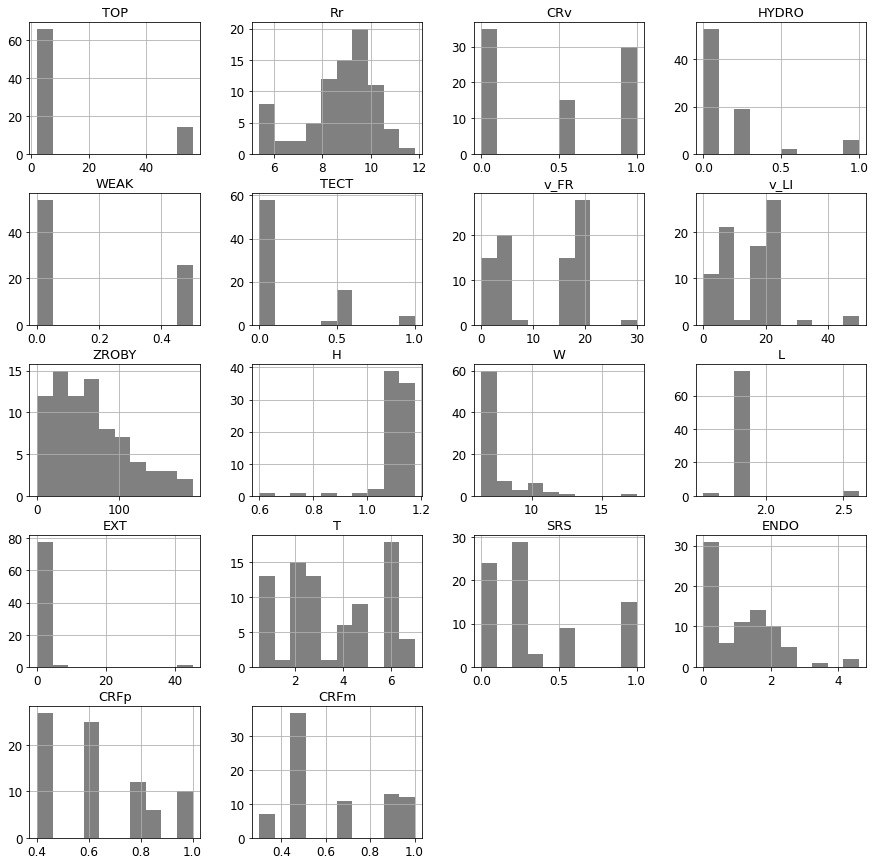

In [8]:
plt.rc('font', size=13)
plt.rc('axes', labelsize=14, titlesize=13)
plt.rc('legend', fontsize=13)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
data.hist(figsize=(15,15), color = 'grey')           #probably outliers in TOP and EXT

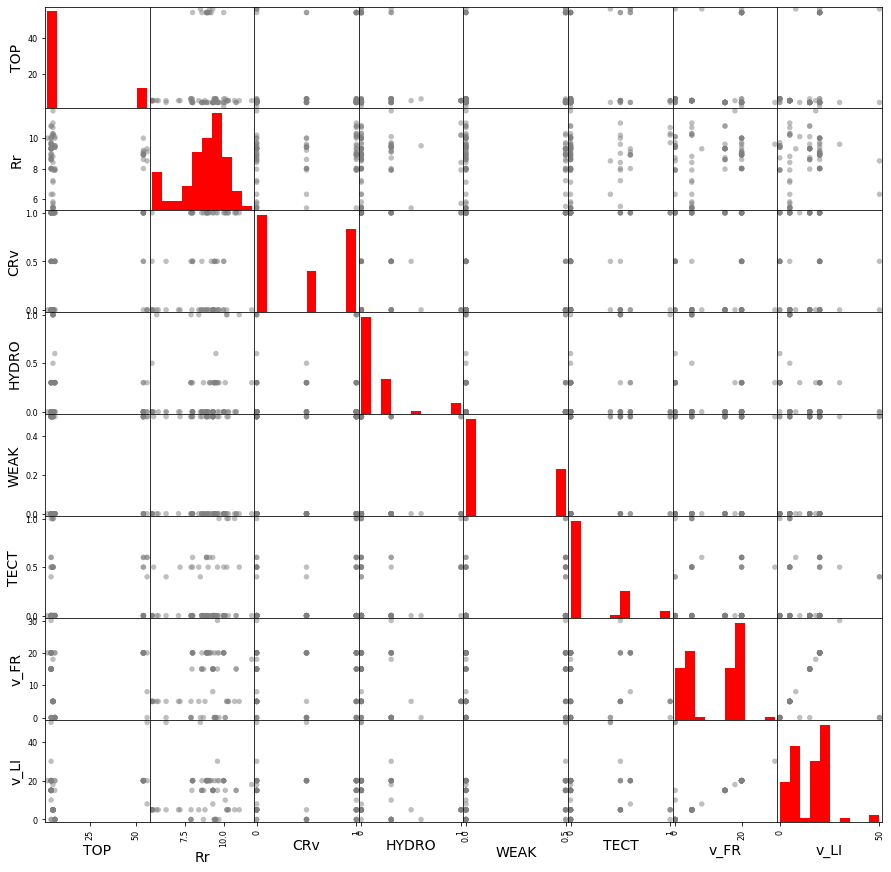

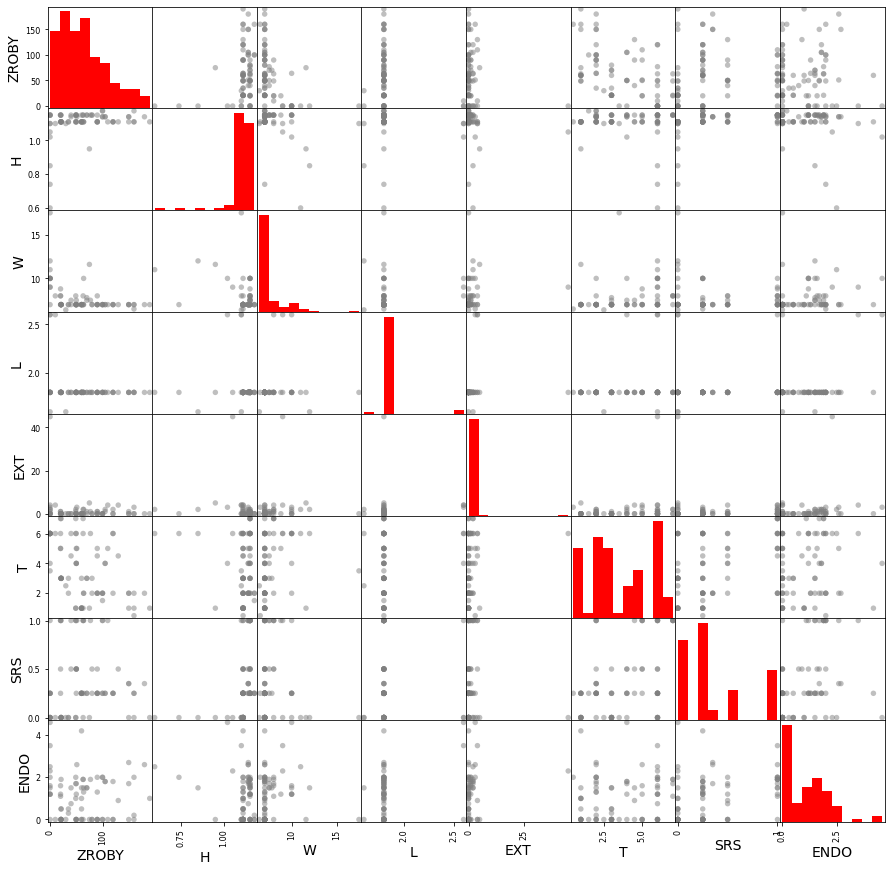

In [12]:
# re-searching for corr (dimensionality reduction in 2018, so there should be no correlation)
data_I = data.loc[:,'TOP':'v_LI'].copy()
data_II = data.loc[:,'ZROBY':'ENDO'].copy()
for plot in (data_I, data_II):
    pd.plotting.scatter_matrix(
        plot,
        figsize = (15,15),
        s = 120,
        color = 'grey',
        hist_kwds={'color':'red'}
    )

In [13]:
# v_li i v-fr - industry justification
data.corr()

,TOP,Rr,CRv,HYDRO,WEAK,TECT,v_FR,v_LI,ZROBY,H,W,L,EXT,T,SRS,ENDO,CRFp,CRFm
TOP,1.000000,0.065101,0.176822,-0.144882,0.306717,0.167803,0.321945,0.368972,-0.161702,0.101536,0.142527,-0.116407,0.268805,0.297507,0.274577,0.113966,0.303269,0.451044
Rr,0.065101,1.000000,0.229011,0.078842,-0.010106,0.150074,0.249651,0.121230,-0.116557,0.089743,0.197163,0.105932,-0.004082,0.058627,-0.083524,0.035178,0.206503,0.073634
CRv,0.176822,0.229011,1.000000,0.039717,0.018549,0.150310,-0.014329,-0.036519,-0.015636,0.157618,-0.016625,0.260434,-0.084480,0.000744,0.317735,0.416522,0.406493,0.376110
HYDRO,-0.144882,0.078842,0.039717,1.000000,-0.091502,0.210166,-0.318841,-0.345364,-0.012870,0.034584,0.085260,0.011438,-0.047900,0.116287,0.184215,0.200951,0.108669,0.061891
WEAK,0.306717,-0.010106,0.018549,-0.091502,1.000000,0.307661,0.132619,0.273742,-0.267838,-0.255525,0.060188,-0.179487,0.178048,0.204091,0.073697,-0.020368,0.171769,0.286446
TECT,0.167803,0.150074,0.150310,0.210166,0.307661,1.000000,-0.076142,0.020294,0.011378,-0.330339,0.071916,-0.153141,0.162436,0.091989,0.113229,0.082113,0.395309,0.331370
v_FR,0.321945,0.249651,-0.014329,-0.318841,0.132619,-0.076142,1.000000,0.613861,-0.238218,0.256487,0.145357,-0.323031,-0.227327,0.098473,0.010717,-0.316309,-0.224114,-0.158103
v_LI,0.368972,0.121230,-0.036519,-0.345364,0.273742,0.020294,0.613861,1.000000,-0.405445,-0.222715,0.319528,-0.132562,0.389389,0.278276,-0.113626,-0.089705,0.106874,0.118059
ZROBY,-0.161702,-0.116557,-0.015636,-0.012870,-0.267838,0.011378,-0.238218,-0.405445,1.000000,0.273628,-0.419005,-0.206132,-0.140517,-0.484424,0.052275,-0.058445,-0.201701,-0.269333
H,0.101536,0.089743,0.157618,0.034584,-0.255525,-0.330339,0.256487,-0.222715,0.273628,1.000000,-0.343338,-0.030031,-0.137058,-0.137347,0.327883,-0.173922,-0.448945,-0.349693


In [14]:
# looking for correlation with labels - expected values
pd.DataFrame([
    data.corr()['CRFp'].sort_values(ascending=False),
    data.corr()['CRFm'],
    data.corr()['CRFp'].sort_values(ascending=False).argsort(),
    data.corr()['CRFm'].sort_values(ascending=False).argsort(),
    ]).round(2)

,CRFp,CRFm,ENDO,W,CRv,TECT,EXT,TOP,L,Rr,WEAK,T,HYDRO,v_LI,SRS,ZROBY,v_FR,H
CRFp,1.00,0.77,0.50,0.45,0.41,0.40,0.30,0.30,0.29,0.21,0.17,0.11,0.11,0.11,0.01,-0.20,-0.22,-0.45
CRFm,0.77,1.00,0.52,0.46,0.38,0.33,0.27,0.45,0.25,0.07,0.29,0.19,0.06,0.12,0.23,-0.27,-0.16,-0.35
CRFp,17.00,16.00,15.00,14.00,13.00,12.00,11.00,10.00,9.00,8.00,7.00,6.00,5.00,4.00,3.00,2.00,1.00,0.00
CRFm,16.00,17.00,15.00,14.00,12.00,11.00,9.00,13.00,8.00,4.00,10.00,6.00,3.00,5.00,7.00,1.00,2.00,0.00


In [16]:
# reverse order, endo and CRv highest - this is justified by the essence of the phenomenon (industrial justification)
data.corr()['CRFp'].sort_values(ascending=False).argsort().loc[
    ["TOP","Rr","CRv","HYDRO","WEAK","TECT","v_FR","v_LI","ZROBY","H","SRS","ENDO"]
    ].sort_values(ascending=False) 

ENDO     15
CRv      13
TECT     12
TOP      10
Rr        8
WEAK      7
HYDRO     5
v_LI      4
SRS       3
ZROBY     2
v_FR      1
H         0
Name: CRFp, dtype: int64

In [17]:
# extras - four parameters which should not affect the value of CRFp labels, however W and EXT are high values
{"TOP","Rr","CRv","HYDRO","WEAK","TECT","v_FR","v_LI","ZROBY","H",'W',"L","EXT","T","SRS","ENDO"} - {"TOP","Rr","CRv","HYDRO","WEAK","TECT","v_FR","v_LI","ZROBY","H","SRS","ENDO"}

{'EXT', 'L', 'T', 'W'}

In [18]:
data.corr()['CRFp'].sort_values(ascending=False).argsort().loc[
    ['EXT', 'L', 'T', 'W']
    ].sort_values(ascending=False) 

W      14
EXT    11
L       9
T       6
Name: CRFp, dtype: int64

There are relatively high features that were not included in the `CRFp` indicator at the expert assessment stage (marked as having no impact)

4. **Przygotować dane pod względem algorytmów maszynowego uczenia** 
* uporządkować cechy typy CATEGORY:
    - określić martwe parametry,
    - rodzaj skał (wg Rr i Rc, usunąć 1),
* standaryzacja
* podzielić zbiory
* martwe parametry <br>
1: brak przykładów w zbiorze dla 1, 3 i 7 <br>
4: za dużo o 0,5

In [19]:
# reduces max - min
data.TOP.replace({56:5, 54:5}, inplace = True)         # zamiana 56 i 54 na 5
data.EXT.replace({45:4}, inplace = True)         # zamiana 56 i 54 na 5 

In [20]:
CRFp = data[['CRFp']]
CRFm = data[['CRFm']]
data_p = data[["TOP","Rr","CRv","HYDRO","WEAK","TECT","v_FR","v_LI","ZROBY","H","SRS","ENDO"]]
#data_m = data[["TOP","Rr","CRv","HYDRO","WEAK","TECT","v_FR","v_LI","ZROBY","H",'W',"L","EXT","T","SRS","ENDO"]]

## Train test split

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    data_p, CRFp, test_size=0.10, random_state=42)
[x.shape for x in [X_train, X_test, y_train, y_test]]


[(72, 12), (8, 12), (72, 1), (8, 1)]

## Stratified Shuffle

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

In [24]:
set_strat_ = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

In [25]:
list_strat_X = []
list_strat_y = []
for train_index, test_index in set_strat_.split(data_p, CRFp):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_stra, X_test_stra = data_p.iloc[train_index], data_p.iloc[test_index]
    y_train_stra, y_test_stra = CRFp.iloc[train_index], CRFp.iloc[test_index]
    list_strat_X.append([X_train_stra, X_test_stra])
    list_strat_y.append([X_train_stra, X_test_stra])

TRAIN: [20 10 71 63 40 25 35 55 24 48 11 15 44 67 53 58 59 23 26  0 13  4 18  9
  8 52 41 57 21 38 28 12 64 75 49 74 70 65 54 32 72 43 22  6 37  5 17 19
 77 60 42  2 14 30 50 76 68 29 46 16 51 27 69  7] TEST: [61 78 73 33 34 79 62  3 66 47 39 45 56 31 36  1]
TRAIN: [30 19 66 68 20 59 41 58  4 13 64 10 17 15 47  6 74  9 25 42 65 79 11 14
  5 60  2 38 78 62 16 73 36  3 45 52 43 24 48 35  1 69 26 57 40 27 55 75
 29 71 46 18 28 33  8 34 50 63 53 70 54 72 44 12] TEST: [ 0 77 31 67 51 61 56 22 37 76 21 49 32 23  7 39]
TRAIN: [ 2 26 67 17  8 13 56 11 30 44  4 10 55 43 38 35 20 31 68 51 63 40 37 61
 46 36 57 23 12 14 45  7 33 53 79 70 69  5 72 16  9 32 29 27 65 74 78  1
 21 47 64 22 76 54 24 15 50 59 66 34 62 41 18  3] TEST: [60 19 42 49 48 25  0 28 52  6 39 77 71 73 75 58]


## StandardScaler

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
scaler = StandardScaler() # for activation function other than tanh
scaler_output = StandardScaler() #for output - It is not necessary (labels c (0,1) )

In [29]:
scaler.fit(data_p)
scaler_output.fit(CRFp)

StandardScaler()

In [30]:
# only splited data
X_train_SS = scaler.transform(X_train)
X_test_SS = scaler.transform(X_test)
y_train_SS = scaler_output.transform(y_train)
y_test_SS = scaler_output.transform(y_test)

In [18]:
# splited by StratifiedShuffleSplit
"""X_train_stra = scaler.transform(X_train_stra)
X_test_stra = scaler.transform(X_test_stra)
y_train_stra = scaler_output.transform(y_train_stra)
y_test_stra = scaler_output.transform(y_test_stra)"""

## MinMacScaler 
`Appropriate due to the range -1:1 of the activation functions tanh` , just for comparison

In [33]:
from sklearn.preprocessing import MinMaxScaler

scalerMinMax = MinMaxScaler(feature_range=(-1, 1))              #for tanh activation function 
scalerMinMax.fit(data_p)

X_trainMM = scalerMinMax.transform(X_train)
X_testMM = scalerMinMax.transform(X_test)

scalerMinMax_output = MinMaxScaler(feature_range=(-1, 1))
scalerMinMax_output.fit(CRFp)

y_trainMM = scalerMinMax_output.transform(y_train)
y_testMM = scalerMinMax_output.transform(y_test)

### SUMMARY

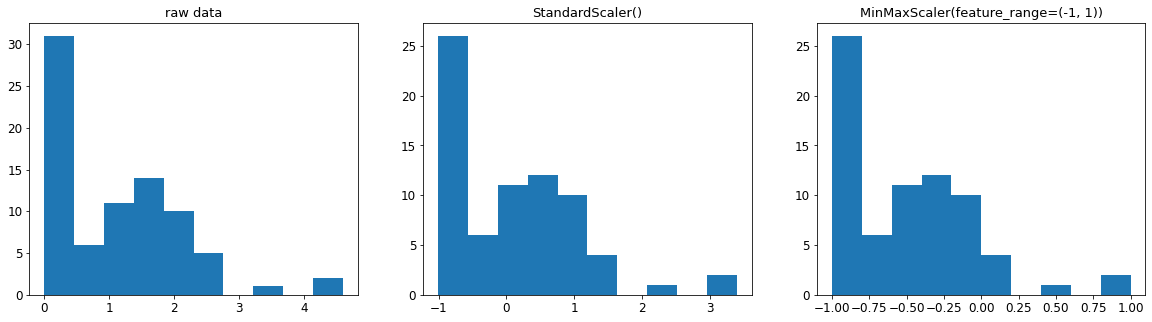

In [41]:
# for example histograms for ENDO - normalization looks good
example = 'ENDO'

plt.figure(figsize= (20,5))

plt.subplot(1, 3, 1)
plt.hist(data[[example]])
plt.gca().title.set_text("raw data")

plt.subplot(1, 3, 2)
plt.hist(pd.DataFrame(X_train_SS, columns = scaler.feature_names_in_)[[example]])
plt.gca().title.set_text(scaler)

plt.subplot(1, 3, 3)
plt.hist(pd.DataFrame(X_trainMM, columns = scalerMinMax.feature_names_in_)[[example]])
plt.gca().title.set_text(scalerMinMax)


# 5. Wybrać i wyuczyć model 
------------------------------------

In [26]:
tf.__version__

'2.9.1'

In [33]:
X_train_ran = np.random.normal(loc=0.0, scale=1.0, size=(80,12))
y_train_ran = np.random.normal(loc=0.0, scale=1.0, size=(80,1))

In [17]:
input_ = tf.keras.layers.Input(shape=(12,))
hidden1_ = tf.keras.layers.Dense(8, activation = 'relu')(input_)
hidden2_ = tf.keras.layers.Dense(4, activation = 'relu')(hidden1_)
output = tf.keras.layers.Dense(1)(hidden2_)

a = checker_dist_box(scalerMinMax,scalerMinMax_output,(X_train_ran,y_train_ran))

a.compute(X_train_ran, y_train_ran, epochs = 70,
                    validation_split = 0.2, shuffle = True, input_ = input_, output = output)

NameError: name 'checker_dist_box' is not defined

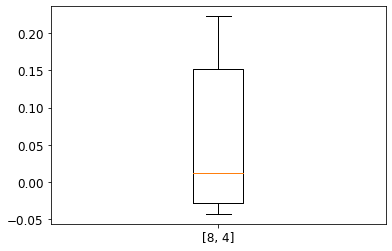

In [86]:
a.plot_box   #Coef Pearson for random input and output

[0.6320273163053499, 0.4624971711314757, 0.5463216985201531, 0.4624953010635332, 0.34378648202865014, 0.6190877288756147, 0.08464203102970544, 0.1131800250662811, 0.23067001382913033, 0.38906894072749626] średnia:  0.388 max:  0.632 struktura:  [7, 1]  !Coef Pearson


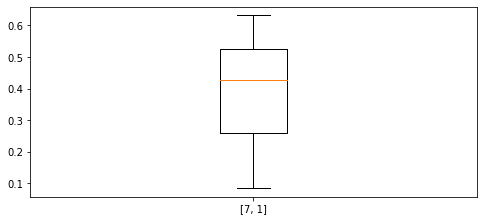

In [107]:
#plot box
b = checker_dist_box(scalerMinMax,scalerMinMax_output,(data_p, CRFp))
b.compute(X_train, y_train, epochs =300,
                    validation_split = 0.2, shuffle = True, neurons_ = 7, function_ = "tanh")
b.plot_box   

[0.4227497219650177, 0.534539911092826, 0.5732963002362303, 0.2878041999908029, 0.5973039606250755, 0.5928582628415262, 0.5904100228794442, 0.49689839393099733, 0.6495667368448598, 0.5411520193473929] średnia:  0.529 max:  0.65 struktura:  [7, 1]  !Coef Pearson


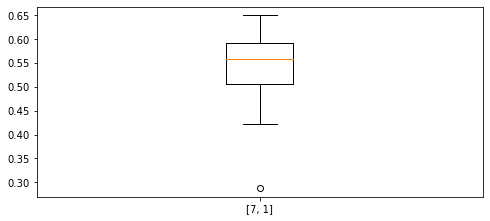

In [117]:
"""Inicjalizacja: LeCuna
Funkcja aktywacji: SELU
Normalizacja: -
Regularyzacja: 
Optymalizator: RMSProp; Nadam
Harmonogram uczenia:"""
c = num1(scalerMinMax,scalerMinMax_output,(data_p, CRFp))
c.compute(X_train, y_train, epochs =300,
                    validation_split = 0.2, shuffle = True, neurons_ = 7, function_ = "selu")
c.plot_box  

[0.5559293546828049, 0.6058436735998196, 0.6354508596731983, 0.6181328174101677, 0.3154732392891393, 0.5499709091821496, 0.624794142130848, 0.541995004382096, 0.6187761619244634, 0.5194107586734307] średnia:  0.559 max:  0.635 struktura:  [6, 1]  !Coef Pearson


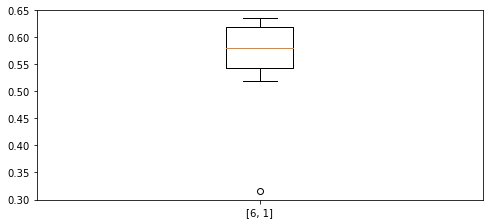

In [118]:
c = num1(scalerMinMax,scalerMinMax_output,(data_p, CRFp))
c.compute(X_train, y_train, epochs =300,
                    validation_split = 0.2, shuffle = True, neurons_ = 6, function_ = "selu")
c.plot_box  

[0.297295447089826, 0.5580666362954643, 0.29095902296651777, 0.5762255183165076, 0.3998296190178619, -0.28924878647430335, 0.0693275529135125, 0.2995497356845643, 0.24244372299881645, 0.6462096385178457] średnia:  0.309 max:  0.646 struktura:  [6, 1]  !Coef Pearson


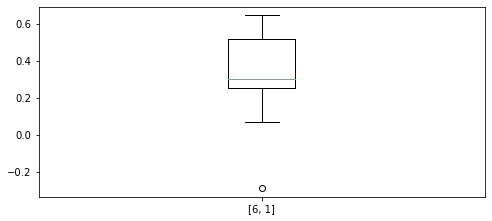

In [121]:
c = num1(scalerMinMax,scalerMinMax_output,(data_p, CRFp))
c.compute(X_train, y_train, epochs =300,
                    validation_split = 0.2, shuffle = True, neurons_ = 6, function_ = "selu")
c.plot_box  

In [29]:
list_output = hold_data() # writes model output to common list
list_output.add_out(model,history)
list_output.print_()

In [89]:
tf.keras.backend.clear_session()
callbacks=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
model = keras.models.Sequential()
model.add(keras.layers.Dense(7, activation = 'selu', input_shape = (12,),kernel_initializer = tf.keras.initializers.LecunNormal()))
model.add(keras.layers.Dense(1,kernel_initializer = tf.keras.initializers.LecunNormal()))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 91        
                                                                 
 dense_1 (Dense)             (None, 1)                 8         
                                                                 
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [18]:
model = keras.models.Sequential()
#model.add(keras.Input(shape=(12,)))
model.add(keras.layers.Dense(7, activation = 'selu', input_shape = (12,),kernel_initializer = tf.keras.initializers.LecunNormal()))
#model.add(keras.layers.Dense(4, activation = 'tanh'))
model.add(keras.layers.Dense(1,kernel_initializer = tf.keras.initializers.LecunNormal()))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 7)                 91        
                                                                 
 dense_4 (Dense)             (None, 1)                 8         
                                                                 
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [115]:
"""Inicjalizacja: He
Funkcja aktywacji: ELU
Normalizacja: brak w płytkiej
Regularyzacja: wczesne zatrzymanie; l2
Optymalizator: RMSPromp; Nadam
Harmonogram uczenia: 1 cykle
    
    keras.layers.Dense(4, activation = "elu", kernel_nitializer="he_normal")"""
tf.keras.backend.clear_session()
del model1
model1 = keras.models.Sequential()
model1.add(keras.layers.Dense(8, activation = 'elu', input_shape = (12,), kernel_regularizer='l2', kernel_initializer = "he_normal"))
model1.add(keras.layers.Dense(1, kernel_regularizer='l2', kernel_initializer = "he_normal"))
model1.summary()
model1.compile(loss = 'mean_squared_error',
             optimizer = 'Nadam',
             metrics = ["MSE"])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 104       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [124]:
# HUBER elu ADAM
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) /2 
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

tf.keras.backend.clear_session()
del model2

opt = tf.keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999)

model2 = keras.models.Sequential()
model2.add(keras.layers.Dense(8, activation = 'elu', input_shape = (12,), kernel_regularizer='l2', kernel_initializer = "he_normal"))
model2.add(keras.layers.Dense(1, kernel_regularizer='l2', kernel_initializer = "he_normal"))
model2.summary()
model2.compile(loss = huber_fn,
             optimizer = opt,
             metrics = ["MSE"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 104       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


c:\Users\Inspektor\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [68]:
#model.layers

In [69]:
#weights, biases = model.get_weights()
#weights, biases

In [70]:
"""import tensorflow_probability as tfp

def pearson_(x,y):
    return tfp.stats.correlation(x,y)"""

'import tensorflow_probability as tfp\n\ndef pearson_(x,y):\n    return tfp.stats.correlation(x,y)'

In [24]:
model.compile(loss = 'mean_squared_error',
             optimizer = 'Nadam',
             metrics = ["MSE"])

In [72]:
X_train.shape

(72, 12)

In [25]:
history = model.fit(X_train, y_train, epochs = 200,
                    validation_split = 0.2, shuffle = True) #steps_per_epoch=32 

2/2 [==============================] - 1s 195ms/step - loss: 3.9029 - MSE: 3.9029 - val_loss: 5.6880 - val_MSE: 5.6880


In [51]:
#StandardScaler
history = model.fit(X_train_SS, y_train_SS, epochs = 400,
                    validation_split = 0.2, shuffle = True, callbacks=[callbacks]) #steps_per_epoch=32- 21s  loss: 0.2737 - MSE: 0.2737 - val_loss: 0.3149 - val_MSE: 0.3149

Epoch 1/400
2/2 [==============================] - 1s 276ms/step - loss: 1.7429 - MSE: 1.7429 - val_loss: 2.8471 - val_MSE: 2.8471
Epoch 2/400
2/2 [==============================] - 0s 57ms/step - loss: 1.7018 - MSE: 1.7018 - val_loss: 2.7992 - val_MSE: 2.7992
Epoch 3/400
2/2 [==============================] - 0s 63ms/step - loss: 1.6660 - MSE: 1.6660 - val_loss: 2.7472 - val_MSE: 2.7472
Epoch 4/400
2/2 [==============================] - 0s 67ms/step - loss: 1.6291 - MSE: 1.6291 - val_loss: 2.6940 - val_MSE: 2.6940
Epoch 5/400
2/2 [==============================] - 0s 55ms/step - loss: 1.5945 - MSE: 1.5945 - val_loss: 2.6415 - val_MSE: 2.6415
Epoch 6/400
2/2 [==============================] - 0s 62ms/step - loss: 1.5582 - MSE: 1.5582 - val_loss: 2.5892 - val_MSE: 2.5892
Epoch 7/400
2/2 [==============================] - 0s 65ms/step - loss: 1.5198 - MSE: 1.5198 - val_loss: 2.5363 - val_MSE: 2.5363
Epoch 8/400
2/2 [==============================] - 0s 59ms/step - loss: 1.4833 - MSE: 1.4

In [91]:
#StandardScaler + strated data
history = model.fit(X_train_stra,  y_train_stra, epochs = 400,
                    validation_data=(X_test_stra ,y_test_stra), shuffle = True, callbacks=[callbacks])

Epoch 1/400
2/2 [==============================] - 2s 302ms/step - loss: 2.5357 - MSE: 2.5357 - val_loss: 1.6130 - val_MSE: 1.6130
Epoch 2/400
2/2 [==============================] - 0s 85ms/step - loss: 2.4775 - MSE: 2.4775 - val_loss: 1.6006 - val_MSE: 1.6006
Epoch 3/400
2/2 [==============================] - 0s 77ms/step - loss: 2.4262 - MSE: 2.4262 - val_loss: 1.5877 - val_MSE: 1.5877
Epoch 4/400
2/2 [==============================] - 0s 85ms/step - loss: 2.3762 - MSE: 2.3762 - val_loss: 1.5745 - val_MSE: 1.5745
Epoch 5/400
2/2 [==============================] - 0s 89ms/step - loss: 2.3249 - MSE: 2.3249 - val_loss: 1.5610 - val_MSE: 1.5610
Epoch 6/400
2/2 [==============================] - 0s 97ms/step - loss: 2.2739 - MSE: 2.2739 - val_loss: 1.5478 - val_MSE: 1.5478
Epoch 7/400
2/2 [==============================] - 0s 72ms/step - loss: 2.2205 - MSE: 2.2205 - val_loss: 1.5343 - val_MSE: 1.5343
Epoch 8/400
2/2 [==============================] - 0s 62ms/step - loss: 2.1653 - MSE: 2.1

In [116]:
#StandardScaler + strated data + elu
history1 = model1.fit(X_train_stra,  y_train_stra, epochs = 500,
                    validation_data=(X_test_stra ,y_test_stra), shuffle = True, callbacks=[callbacks])

Epoch 1/500
2/2 [==============================] - 2s 363ms/step - loss: 5.3019 - MSE: 5.1050 - val_loss: 4.1094 - val_MSE: 3.9128
Epoch 2/500
2/2 [==============================] - 0s 63ms/step - loss: 5.2093 - MSE: 5.0128 - val_loss: 4.0673 - val_MSE: 3.8711
Epoch 3/500
2/2 [==============================] - 0s 69ms/step - loss: 5.1311 - MSE: 4.9349 - val_loss: 4.0250 - val_MSE: 3.8291
Epoch 4/500
2/2 [==============================] - 0s 55ms/step - loss: 5.0507 - MSE: 4.8549 - val_loss: 3.9814 - val_MSE: 3.7859
Epoch 5/500
2/2 [==============================] - 0s 66ms/step - loss: 4.9701 - MSE: 4.7747 - val_loss: 3.9367 - val_MSE: 3.7416
Epoch 6/500
2/2 [==============================] - 0s 67ms/step - loss: 4.8830 - MSE: 4.6880 - val_loss: 3.8915 - val_MSE: 3.6968
Epoch 7/500
2/2 [==============================] - 0s 79ms/step - loss: 4.8009 - MSE: 4.6063 - val_loss: 3.8459 - val_MSE: 3.6516
Epoch 8/500
2/2 [==============================] - 0s 72ms/step - loss: 4.7178 - MSE: 4.5

In [125]:

#StandardScaler + strated data + elu + hb
history2 = model2.fit(X_train_stra,  y_train_stra, epochs = 500,
                    validation_data=(X_test_stra ,y_test_stra), shuffle = True, callbacks=[callbacks])

Epoch 1/500
2/2 [==============================] - 1s 284ms/step - loss: 0.9849 - MSE: 2.4609 - val_loss: 1.0079 - val_MSE: 2.2382
Epoch 2/500
2/2 [==============================] - 0s 63ms/step - loss: 0.9666 - MSE: 2.3897 - val_loss: 0.9968 - val_MSE: 2.2007
Epoch 3/500
2/2 [==============================] - 0s 59ms/step - loss: 0.9516 - MSE: 2.3360 - val_loss: 0.9860 - val_MSE: 2.1648
Epoch 4/500
2/2 [==============================] - 0s 70ms/step - loss: 0.9341 - MSE: 2.2711 - val_loss: 0.9751 - val_MSE: 2.1292
Epoch 5/500
2/2 [==============================] - 0s 64ms/step - loss: 0.9191 - MSE: 2.2157 - val_loss: 0.9646 - val_MSE: 2.0952
Epoch 6/500
2/2 [==============================] - 0s 63ms/step - loss: 0.9021 - MSE: 2.1540 - val_loss: 0.9546 - val_MSE: 2.0636
Epoch 7/500
2/2 [==============================] - 0s 67ms/step - loss: 0.8860 - MSE: 2.0984 - val_loss: 0.9445 - val_MSE: 2.0323
Epoch 8/500
2/2 [==============================] - 0s 62ms/step - loss: 0.8718 - MSE: 2.0

In [82]:
list_output.add_out(*[
    'model', 
    round(history.history['loss'][-1],3),
    model.layers[1].kernel_initializer.__class__.__name__,
    ' - - ',
    model.layers[1].activation.__name__,
    model.optimizer.__class__.__name__]
    )
" 'NET','MSE','Kernel INI','OTHER', 'EXTRAS#1','EXTRAS#2' "

NameError: name 'list_output' is not defined

In [ ]:
list_output.print_()

     NET  MAX_MSE    TUNER_KERAS  OTHER EXTRAS#1 EXTRAS#2
0  model     0.09  GlorotUniform   - -    linear      SGD


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 7)                 91        
                                                                 
 dense_4 (Dense)             (None, 4)                 32        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 128
Trainable params: 128
Non-trainable params: 0
_________________________________________________________________


In [32]:
def plot_hist(history_, grid = True):
    "wizualizuje dane z pliku history.history"
    
    pd.DataFrame(getattr(history_, "history")).plot(figsize = (8,5), style=["r--", "r-x", "g--", "g-*"])
    plt.grid(grid)
    plt.show()

def plot_sc_all(scaler_input, scaler_output, model_, data, out):
    
    y_pred_ = model_(scaler_input.transform(data))
    y_pred_ = np.ravel(scaler_output.inverse_transform(y_pred_))
    y_true_ = np.ravel(out)
    print('Pearson correlation coefficient: {}'.format(measures.pearsonr(y_pred_, y_true_)[0].round(2)))
          
    pd.DataFrame.from_dict({
        "y_pred": y_pred_,
        "y_true": y_true_
    }).plot.scatter('y_true',"y_pred" , c='r',ylim =(0,1.2),xlim =(0,1.2))
    plt.grid()
    plt.plot([0,1],[0,1], 'b--')
    plt.show()

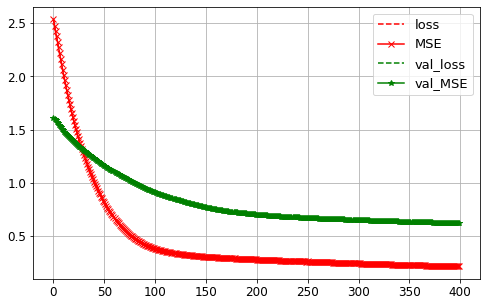

In [92]:
plot_hist(history)

Pearson correlation coefficient: 0.84


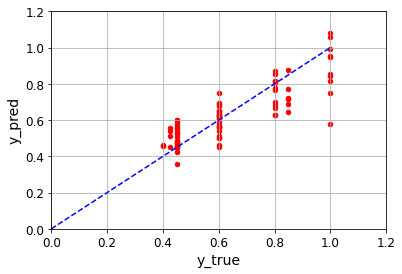

In [93]:
plot_sc_all(scaler, scaler_output, model, data_p, CRFp)

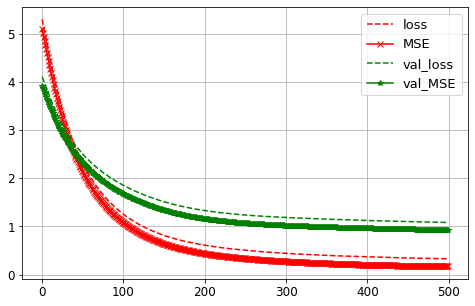

Pearson correlation coefficient: 0.83


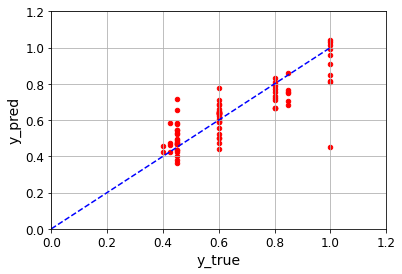

In [117]:
# for elu + L2
plot_hist(history1)
plot_sc_all(scaler, scaler_output, model1, data_p, CRFp)

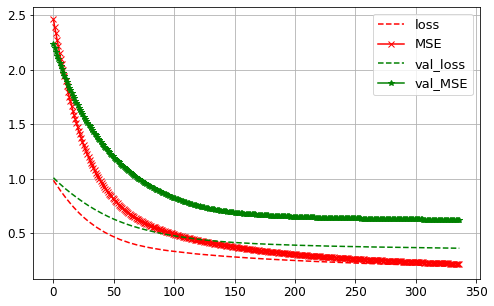

Pearson correlation coefficient: 0.84


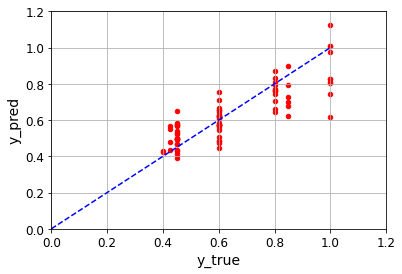

In [126]:
# for elu + L2 HUBER ADAM
plot_hist(history2)
plot_sc_all(scaler, scaler_output, model2, data_p, CRFp)

In [26]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) /2 
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

callbacks=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
#1
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=4, default=2)
    n_neurons = hp.Int("n_neurons", min_value=3, max_value=11)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["RMSprop", "Nadam", "Adam"])
    
    optimizer = {
        'RMSprop': tf.keras.optimizers.RMSprop(
            learning_rate=learning_rate,
            rho=0.9,
            momentum=0.0,
            epsilon=1e-07,
            centered=False,
            name='RMSprop'
            ),
        'Nadam': tf.keras.optimizers.Nadam(
            learning_rate=learning_rate,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07,
            name='Nadam'
            ),
        "Adam": tf.keras.optimizers.Adam(
            lr=0.001,
            beta_1=0.9, 
            beta_2=0.999
            )
    }.get(optimizer)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(
            n_neurons, 
            kernel_initializer='he_normal', 
            activation="elu",
            kernel_regularizer='l2')
            )
    model.add(tf.keras.layers.Dense(
        1, 
        kernel_initializer='he_normal', 
        activation="elu",
        kernel_regularizer='l2')
        )
    model.compile(loss=huber_fn, optimizer=optimizer, metrics=["MSE"])
    return model

In [27]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="MSE", max_trials=10, overwrite=True,
    directory="proba_Kerac", project_name="my_SSN_keras", seed=42)

random_search_tuner.search(X_train_stra, y_train_stra, epochs=300,
                           validation_data=(X_test_stra, y_test_stra),callbacks=[callbacks])

top3_models = random_search_tuner.get_best_models(num_models = 3)

best_model = top3_models[0]

random_search_tuner.get_best_hyperparameters(num_trials = 3)
random_search_tuner.get_best_hyperparameters(num_trials = 3)[0].values

Trial 10 Complete [00h 00m 22s]
MSE: 0.19618262350559235

Best MSE So Far: 0.18220394849777222
Total elapsed time: 00h 02m 17s
INFO:tensorflow:Oracle triggered exit


{'n_hidden': 2,
 'n_neurons': 5,
 'learning_rate': 0.00905127409782462,
 'optimizer': 'Adam'}

In [31]:
#FINAL StandardScaler + strated data + elu + hb + ADAM

# HUBER elu ADAM
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) /2 
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

tf.keras.backend.clear_session()
try:
    del modelF
except:
    pass

opt = tf.keras.optimizers.Adam(lr=0.00905,beta_1=0.9, beta_2=0.999)

modelF = keras.models.Sequential()
modelF.add(keras.layers.Dense(5, activation = 'elu', input_shape = (12,), kernel_regularizer='l2', kernel_initializer = "he_normal"))
modelF.add(keras.layers.Dense(5, activation = 'elu', input_shape = (12,), kernel_regularizer='l2', kernel_initializer = "he_normal"))
modelF.add(keras.layers.Dense(1, kernel_regularizer='l2', kernel_initializer = "he_normal"))
modelF.summary()
modelF.compile(loss = huber_fn,
             optimizer = opt,
             metrics = ["MSE"])

historyF = modelF.fit(X_train_stra,  y_train_stra, epochs = 500,
                    validation_data=(X_test_stra ,y_test_stra), shuffle = True, callbacks=[callbacks])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 65        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500


C:\Users\Inspektor\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 0s 124ms/step - loss: 1.1472 - MSE: 2.6794 - val_loss: 1.2720 - val_MSE: 2.9807
Epoch 2/500
2/2 [==============================] - 0s 19ms/step - loss: 0.9691 - MSE: 2.0006 - val_loss: 1.1447 - val_MSE: 2.5985
Epoch 3/500
2/2 [==============================] - 0s 24ms/step - loss: 0.8216 - MSE: 1.5096 - val_loss: 1.0450 - val_MSE: 2.3118
Epoch 4/500
2/2 [==============================] - 0s 22ms/step - loss: 0.7069 - MSE: 1.1581 - val_loss: 0.9675 - val_MSE: 2.0860
Epoch 5/500
2/2 [==============================] - 0s 27ms/step - loss: 0.6257 - MSE: 0.9345 - val_loss: 0.9095 - val_MSE: 1.9098
Epoch 6/500
2/2 [==============================] - 0s 23ms/step - loss: 0.5644 - MSE: 0.7786 - val_loss: 0.8667 - val_MSE: 1.7807
Epoch 7/500
2/2 [==============================] - 0s 25ms/step - loss: 0.5252 - MSE: 0.6754 - val_loss: 0.8317 - val_MSE: 1.6753
Epoch 8/500
2/2 [==============================] - 0s 25ms/step - loss: 0.4974 - MSE: 0.6103 - val_lo

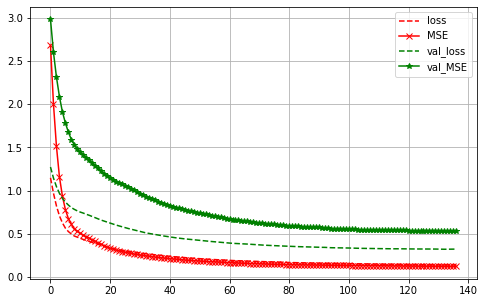

Pearson correlation coefficient: 0.89


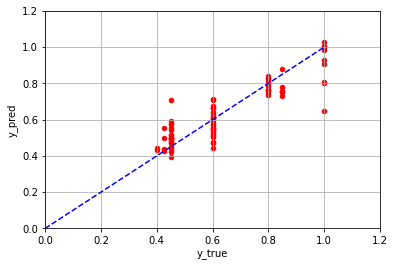

In [33]:
plot_hist(historyF)
plot_sc_all(scaler, scaler_output, modelF, data_p, CRFp)

Using the Huber activation function increased the value of the metric from `0.85 to 0.89 (Pearson correlation coefficient)`

Three times repeated prediction made for four structures. Best result for `X` neurons (also upper limit of the test). This proves the necessity to re-test for a larger scope (10, 11 and 12 neuronos). Experience shows that it may have too many degrees of freedom.
Additionally, an increase in the number of neurons reduces the variance (*vide* - box plot). Which increases the repeatability of a better result. Learning curves don't look bad. 

The mean and the maximum value of MAE are similar for the `MAE` and `Huber_fn` functions, but in the second case, the learning curves are smoother

6. Dostroić model
------------------

In [ ]:
# CLASSIC STYLE (Seq)
model = keras.models.Sequential()
model.add(keras.layers.Dense(7, activation = 'relu', input_shape = (12,), kernel_initializer = 'he_normal'))
model.add(keras.layers.Dense(4, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(keras.layers.Dense(1))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 91        
                                                                 
 dense_1 (Dense)             (None, 4)                 32        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 128
Trainable params: 128
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = 'mean_squared_error',
             optimizer = 'SGD',
             metrics = ["MAE"])

In [ ]:
history = model.fit(X_train, y_train, epochs = 100,
                    validation_split = 0.2, shuffle = True)

## keras_tuner

In [ ]:
import keras_tuner as kt

In [ ]:
# need: import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=4, default=2)
    n_neurons = hp.Int("n_neurons", min_value=3, max_value=11)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    
    optimizer = {
        'sgd': tf.keras.optimizers.SGD(learning_rate=learning_rate),
        'adam': tf.keras.optimizers.Adam(learning_rate=learning_rate)
    }.get(optimizer)
    

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="relu"))
    model.compile(loss=huber_fn, optimizer=optimizer,
                  metrics=["MAE"])
    return model

In [ ]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="MAE", max_trials=10, overwrite=True,
    directory="proba_Kerac", project_name="my_SSN_keras", seed=42)

In [ ]:
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_test, y_test))

Trial 10 Complete [00h 00m 01s]
MAE: 0.6503471732139587

Best MAE So Far: 0.3700334429740906
Total elapsed time: 00h 00m 12s
INFO:tensorflow:Oracle triggered exit


In [ ]:
top3_models = random_search_tuner.get_best_models(num_models = 3)

In [ ]:
best_model = top3_models[0]

In [ ]:
random_search_tuner.get_best_hyperparameters(num_trials = 3)
random_search_tuner.get_best_hyperparameters(num_trials = 3)[0].values

{'n_hidden': 2,
 'n_neurons': 5,
 'learning_rate': 0.00905127409782462,
 'optimizer': 'sgd'}

7. Zaprezentować rozwiązanie **(...)** 
------------------

# assert `MSE_new > MSE_old`
`MSE_old`

In [109]:
#old MSE for validation data only
old_output = pd.DataFrame(
    {'old MSE' :[0.028,0.014,0.018,0.0077,0.013,0.0086],
    'old R': [0.86,0.87,0.85,0.88,0.90,0.85]}, 
    index=["13-19-1", '13-16-1','13-13-1','13-10-1','13-7-1','13-4-1']
)
old_output

,old MSE,old R
13-19-1,0.0280,0.86
13-16-1,0.0140,0.87
13-13-1,0.0180,0.85
13-10-1,0.0077,0.88
13-7-1,0.0130,0.90
13-4-1,0.0086,0.85


In [110]:
print("The best result for structure {} was R = {}".format(old_output.index[old_output['old R'].argmax()], old_output['old R'].max()))

The best result for structure 13-7-1 was R = 0.9


In [111]:
target_ = data.CRFp.tolist() # data from from field research

In [112]:
# output from from old net - Matlab 2018
output_old = [0.80977, 0.93382, 0.92905, 0.91151, 0.92878, 0.93174, 0.93537,
0.97727, 0.9391 , 0.92472, 0.63107, 0.63377, 0.69431, 0.63008,
0.53391, 0.50832, 0.66687, 0.80758, 0.54027, 0.54112, 0.74659,
0.54157, 0.53765, 0.5331 , 0.59821, 0.81597, 0.81597, 0.68348,
0.8483 , 0.8136 , 0.54067, 0.53769, 0.8972 , 0.79948, 0.56671,
0.53319, 0.83307, 0.87477, 0.53669, 0.56079, 0.77923, 0.56878,
0.66505, 0.68106, 0.59562, 0.59636, 0.53669, 0.70215, 0.68469,
0.77413, 0.79795, 0.82999, 0.61131, 0.56482, 0.546  , 0.53844,
0.50207, 0.55816, 0.90946, 0.75523, 0.53619, 0.84741, 0.73992,
0.78393, 0.81649, 0.91975, 0.78775, 0.53991, 0.55218, 0.58523,
0.58523, 0.55251, 0.5587 , 0.56734, 0.58523, 0.54263, 0.54233,
0.57033, 0.57233, 0.57475]

In [116]:
def tf_eval(target_, output:list):
    "output:list evaluate data new neural net for target_ data"

    mse = tf.keras.losses.MeanSquaredError()
    h = tf.keras.losses.Huber()
    print(f'mse {mse(target_,output).numpy():.3}')
    print(f'huber {h(target_,output).numpy():.2}')

tf_eval(target_, output_old)

mse 0.0125
huber 0.0063


In [117]:
import tensorflow_probability as tfp

In [124]:
def tf_eval_pearson(target_, output:list):
    "returns the Pearson correlation coefficient for the given arguments"

    target_ = tf.convert_to_tensor(target_)
    output = tf.convert_to_tensor(output)
    target_ = tf.reshape(target_,(-1,1))
    output = tf.reshape(output,(-1,1))
    return tfp.stats.correlation(target_,output).numpy()[0,0].round(2)

tf_eval_pearson(target_, output_old)

0.85

------------------
7. Zaprezentować rozwiązanie (vide - ocena modelu)
8. Przygotowć potok. Podzielić na katologi produkcyjne. Pokryć sieć testami jednostkowymi. 
------------------


In [57]:
def MinMaxScaler_(MINMAXSCALER):
    return MINMAXSCALER
    
scaler_to_net_ = MinMaxScaler_(scalerMinMax)
scaler_to_net_out_ = MinMaxScaler_(scalerMinMax_output)

In [112]:
class in_scaler_tf(tf.keras.layers.Layer):
    def __init__(self, scaler = scalerMinMax):
        self.scaler = scaler
        super(in_scaler_tf,self).__init__()
        
    def call(self, INPUT):
        INPUT *= tf.convert_to_tensor(self.scaler.scale_.tolist(), tf.float32)
        INPUT += tf.convert_to_tensor(self.scaler.min_.tolist(), tf.float32)
        INPUT = tf.experimental.numpy.clip(INPUT, self.scaler.feature_range[0], self.scaler.feature_range[1])
        return INPUT

In [113]:
class out_scaler_tf(tf.keras.layers.Layer):
    def __init__(self, scaler = scalerMinMax_output):
        self.scaler = scaler
        super(out_scaler_tf,self).__init__()
        
    def call(self, INPUT):
        INPUT -= self.scaler.min_
        INPUT /= self.scaler.scale_
        return INPUT

In [115]:
model = keras.models.Sequential()
model.add(in_scaler_tf())
model.add(keras.layers.Dense(7, activation = 'relu', input_shape = (12,), kernel_initializer = 'he_normal'))
model.add(keras.layers.Dense(4, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(keras.layers.Dense(1))
model.add(out_scaler_tf())
model.compile(loss = 'mean_squared_error',
             optimizer = 'SGD',
             metrics = ["MAE"])
history = model.fit(X_train, y_train, epochs = 100,
                    validation_split = 0.2, shuffle = True)

Epoch 1/100
2/2 [==============================] - 1s 178ms/step - loss: 0.1188 - MAE: 0.2937 - val_loss: 0.0971 - val_MAE: 0.2440
Epoch 2/100
2/2 [==============================] - 0s 23ms/step - loss: 0.1110 - MAE: 0.2800 - val_loss: 0.0910 - val_MAE: 0.2310
Epoch 3/100
2/2 [==============================] - 0s 33ms/step - loss: 0.1042 - MAE: 0.2681 - val_loss: 0.0856 - val_MAE: 0.2190
Epoch 4/100
2/2 [==============================] - 0s 34ms/step - loss: 0.0981 - MAE: 0.2574 - val_loss: 0.0808 - val_MAE: 0.2074
Epoch 5/100
2/2 [==============================] - 0s 22ms/step - loss: 0.0926 - MAE: 0.2465 - val_loss: 0.0766 - val_MAE: 0.1972
Epoch 6/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0878 - MAE: 0.2373 - val_loss: 0.0728 - val_MAE: 0.1886
Epoch 7/100
2/2 [==============================] - 0s 30ms/step - loss: 0.0835 - MAE: 0.2283 - val_loss: 0.0696 - val_MAE: 0.1807
Epoch 8/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0797 - MAE: 0.2

9. **Uruchomić**, monitorować i utrzymać system./
------------------

In [ ]:
"""
import joblib

new_model = tf.keras.models.load_model('ANNmodel')
out_ = joblib.load('scaler2.pkl')
in_ = joblib.load('scalerMinMax.pkl')

data = pd.read_excel("SNN.xls",header = None, sheet_name= 1)
"""

'\nimport joblib\n\nnew_model = tf.keras.models.load_model(\'ANNmodel\')\nout_ = joblib.load(\'scaler2.pkl\')\nin_ = joblib.load(\'scalerMinMax.pkl\')\n\ndate = pd.read_excel("SNN.xls",header = None, sheet_name= 1)\n'

In [ ]:
# DOCKER 
# docker run -it --rm -v "C:\\Users\\Inspektor\\ANNmodel:/models/siecNN/1" -p 8500:8500 -p 8501:8501 -e MODEL_NAME=siecNN tensorflow/serving

In [ ]:
#SSN_CRFp(data_p[:10], in_, out_,new_model)  # 10 dodatkowych danych testowych

#in_.transform(data_p[:10])

# new_model.predict( ... )
# out_.inverse_transform( ...)

In [4]:
import json

def _to_pred(to_pred, in_):
    request_json = json.dumps({
        "signature_name": "serving_default",
        "instances": in_.transform(to_pred.tolist()),
    })
    return request_json

request_json = _to_pred([[1,2,3,4,5,6,7,8,6,5,4]], in_)

In [ ]:
#siec NN
import requests

server_url = "http://localhost:8501/v1/models/siecNN:predict"
response = requests.post(server_url, data=request_json)
response.raise_for_status()  # raise an exception in case of error
response = response.json()

In [ ]:
# output scaler
out_.inverse_transform(
    response['predictions']
)


# THE END

extras

In [ ]:
np.save("ha.npy", X_train.to_numpy()[0:3].reshape(-1,12,1))

In [ ]:
# bez normalizacji
!saved_model_cli run --dir ANNmodel --tag_set serve --signature_def serving_default --inputs {'flatten_input'}=ha.npy

Result for output key dense_1:
[[0.76234436]
 [0.78554124]
 [0.78554124]]


2022-06-10 22:10:39.358681: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-06-10 22:10:39.358735: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-10 22:10:52.723844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-06-10 22:10:52.723898: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-10 22:10:52.732035: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-RR620JF
2022-06-10 22:10:52.732241: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-RR620JF
2022-06-10 22:10:52.733264: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is

# ZAMIENIA NAZWY KOLUMN

In [ ]:
#odczytanie excela oraz konwersja z ',' na '.'
br_dane = pd.read_excel('SSN\ANN.xlsx', sheet_name = 'tabela', engine = 'openpyxl', thousands=".")

In [ ]:
br_dane.columns

Index(['Rodzaj skał stropowych', 'Wytrzymałość na rozciąganie',
       'Spękania pionowe', 'Zawodnienie', 'Płaszczyzny osłabienia',
       'Występowanie zaburzeń zalegania złoża ',
       'Średni postęp miesięczny frontu', 'Średni postęp mieś. likwidacji',
       'Występowanie zaszłości (stare wyrobiska, zroby)',
       'Głębokość zalegania złoża', 'Rzeczywista szerokość', 'Długość kotwi',
       'Dodatkowa obudowa', 'Czas istnienia wyrobiska',
       'Opadnięcia elementów SRS',
       'Rozwarstwienia stwierdzone badaniem endoskopowym', 'Predyspozycja',
       'Możliwość utrzymania'],
      dtype='object')

In [ ]:
{a:a.upper() for a in br_dane.columns}

{'Rodzaj skał stropowych': 'RODZAJ SKAŁ STROPOWYCH',
 'Wytrzymałość na rozciąganie': 'WYTRZYMAŁOŚĆ NA ROZCIĄGANIE',
 'Spękania pionowe': 'SPĘKANIA PIONOWE',
 'Zawodnienie': 'ZAWODNIENIE',
 'Płaszczyzny osłabienia': 'PŁASZCZYZNY OSŁABIENIA',
 'Występowanie zaburzeń zalegania złoża ': 'WYSTĘPOWANIE ZABURZEŃ ZALEGANIA ZŁOŻA ',
 'Średni postęp miesięczny frontu': 'ŚREDNI POSTĘP MIESIĘCZNY FRONTU',
 'Średni postęp mieś. likwidacji': 'ŚREDNI POSTĘP MIEŚ. LIKWIDACJI',
 'Występowanie zaszłości (stare wyrobiska, zroby)': 'WYSTĘPOWANIE ZASZŁOŚCI (STARE WYROBISKA, ZROBY)',
 'Głębokość zalegania złoża': 'GŁĘBOKOŚĆ ZALEGANIA ZŁOŻA',
 'Rzeczywista szerokość': 'RZECZYWISTA SZEROKOŚĆ',
 'Długość kotwi': 'DŁUGOŚĆ KOTWI',
 'Dodatkowa obudowa': 'DODATKOWA OBUDOWA',
 'Czas istnienia wyrobiska': 'CZAS ISTNIENIA WYROBISKA',
 'Opadnięcia elementów SRS': 'OPADNIĘCIA ELEMENTÓW SRS',
 'Rozwarstwienia stwierdzone badaniem endoskopowym': 'ROZWARSTWIENIA STWIERDZONE BADANIEM ENDOSKOPOWYM',
 'Predyspozycja': 'PREDY

In [ ]:
new_name = {'Rodzaj skał stropowych': 'TOP',
 'Wytrzymałość na rozciąganie': 'Rr',
 'Spękania pionowe': 'CRv',
 'Zawodnienie': 'HYDRO',
 'Płaszczyzny osłabienia': 'WEAK',
 'Występowanie zaburzeń zalegania złoża ': 'TECT',
 'Średni postęp miesięczny frontu': 'v_FR',
 'Średni postęp mieś. likwidacji': 'v_LI',
 'Występowanie zaszłości (stare wyrobiska, zroby)': 'ZROBY',
 'Głębokość zalegania złoża': 'H',
 'Rzeczywista szerokość': 'W',
 'Długość kotwi': 'L',
 'Dodatkowa obudowa': 'EXT',
 'Czas istnienia wyrobiska': 'T',
 'Opadnięcia elementów SRS': 'SRS',
 'Rozwarstwienia stwierdzone badaniem endoskopowym': 'ENDO',
 'Predyspozycja': 'CRFp',
 'Możliwość utrzymania': 'CRFm'}
new_name.values()

dict_values(['TOP', 'Rr', 'CRv', 'HYDRO', 'WEAK', 'TECT', 'v_FR', 'v_LI', 'ZROBY', 'H', 'W', 'L', 'EXT', 'T', 'SRS', 'ENDO', 'CRFp', 'CRFm'])

In [ ]:
# nowe nazwy
br_dane.columns = new_name.values()

In [ ]:
br_dane.head()

,TOP,Rr,CRv,HYDRO,WEAK,TECT,v_FR,v_LI,ZROBY,H,W,L,EXT,T,SRS,ENDO,CRFp,CRFm
0,5,11.8,0.0,0.3,0.0,0.0,18,18,0,1.10,17.5,1.8,0,3.5,0.0,0.0,1.0,1.0
1,4,9.6,0.0,0.3,0.5,0.5,30,30,0,0.85,12.0,1.6,2,6.0,0.0,1.5,1.0,1.0
2,56,9.3,0.0,0.0,0.0,0.6,8,8,75,0.95,11.6,1.8,5,1.0,0.0,0.0,1.0,1.0
3,4,8.7,1.0,0.3,0.0,0.0,0,0,0,1.02,10.0,2.6,3,4.0,0.0,4.6,1.0,1.0
4,4,9.7,0.0,0.0,0.5,1.0,0,0,0,0.74,7.0,1.8,0,6.0,0.0,2.0,1.0,1.0


In [ ]:
br_dane.to_csv('SSN\out1.csv', index = False)

In [ ]:
br_dane.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TOP     80 non-null     int64  
 1   Rr      80 non-null     float64
 2   CRv     80 non-null     float64
 3   HYDRO   80 non-null     float64
 4   WEAK    80 non-null     float64
 5   TECT    80 non-null     float64
 6   v_FR    80 non-null     int64  
 7   v_LI    80 non-null     int64  
 8   ZROBY   80 non-null     int64  
 9   H       80 non-null     float64
 10  W       80 non-null     float64
 11  L       80 non-null     float64
 12  EXT     80 non-null     int64  
 13  T       80 non-null     float64
 14  SRS     80 non-null     float64
 15  ENDO    80 non-null     float64
 16  CRFp    80 non-null     float64
 17  CRFm    80 non-null     float64
dtypes: float64(13), int64(5)
memory usage: 11.4 KB


GOTOWE - NAZWY KOLUMN ZAMIENIONE

# OKREŚLIĆ MARTWE WARTOŚCI (NIE UŻYTE)
1: 1,3,7 <br>
4: za dużo o 0,5

In [ ]:
[br_dane[a].unique() for a in br_dane]

[array([ 5,  4, 56,  6, 54,  2], dtype=int64),
 array([11.8 ,  9.6 ,  9.3 ,  8.7 ,  9.7 ,  8.5 , 10.1 ,  6.3 ,  9.1 ,
         9.4 ,  7.9 ,  8.9 ,  5.4 ,  8.72,  7.96,  9.5 , 10.  ,  9.  ,
         8.  ,  9.2 ,  8.6 ,  5.7 ,  7.1 ,  5.8 ,  5.5 ,  8.8 , 10.2 ,
         8.4 , 11.  , 10.3 , 10.7 ,  7.2 ,  9.31,  8.59, 10.8 ]),
 array([0. , 1. , 0.5]),
 array([0.3, 0. , 0.5, 0.6, 1. ]),
 array([0. , 0.5]),
 array([0. , 0.5, 0.6, 1. , 0.4]),
 array([18, 30,  8,  0, 20,  5, 15], dtype=int64),
 array([18, 30,  8,  0, 50, 15, 10, 20,  5], dtype=int64),
 array([  0,  75,  10,  30, 180, 150,  40, 160, 100,  60, 190, 105,  51,
         50,  80,  20,  70,  90,  63,  49,  77,  21, 130, 120,  64, 110,
         35], dtype=int64),
 array([1.1  , 0.85 , 0.95 , 1.02 , 0.74 , 1.05 , 0.6  , 1.14 , 1.175,
        1.11 , 1.15 ]),
 array([17.5, 12. , 11.6, 10. ,  7. ,  9. ,  8. , 11. ,  6.4,  7.5,  8.8,
         7.8,  6.5]),
 array([1.8, 1.6, 2.6]),
 array([ 0,  2,  5,  3, 45,  4,  1], dtype=int64),
 array([

## Huber loss plot

Text(0.5, 1.0, 'Huber loss')

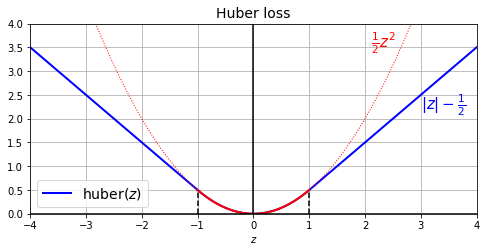

In [ ]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)

# Pre-prepared network aka `2018`

In [ ]:
import joblib

new_model = tf.keras.models.load_model('ANNmodel')
out_ = joblib.load('scaler2.pkl')
in_ = joblib.load('scalerMinMax.pkl')
data = pd.read_excel("SNN.xls",header = None, sheet_name= 1)

def SSN_CRFp(data, input_scaler, output_scaler, model, flatten = True):
    predict_ = output_scaler.inverse_transform(model.predict(input_scaler.transform(data))).round(5)
    if flatten:
        return predict_.flatten()
    else:
        return predict_   

SSN_CRFp(data_p, in_, out_,new_model)

NameError: name 'date_p' is not defined

In [ ]:
in_ = joblib.load('scalerMinMax.pkl')